In [1]:
from collections import Counter
from PIL import Image as im
import numpy as np
from matplotlib import pyplot as plt
import os
import keras as k
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical                 
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, RandomRotation, RandomFlip, RandomZoom, RandomContrast
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from PIL import ImageFile
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import tensorflow_addons as tfa

tf.config.set_soft_device_placement(True) 
ImageFile.LOAD_TRUNCATED_IMAGES = True
img_res = [224, 224]

/Users/wbowers/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# load dataset
def load_data(pathname):
    images = []
    labels = []
    dataset = pathname
    categories = os.listdir(os.getcwd() + "/" + dataset)
    weird_count = 0
    count = 0

    for i in tqdm(range(len(categories))):
        for filename in tqdm(os.listdir(os.getcwd() + '/' + dataset + '/' + categories[i] + '/'), leave=False):
            image = im.open(os.getcwd() + '/' + dataset + '/' + categories[i] + '/' + filename)
            np_img = np.array(image.resize((img_res[1], img_res[0])))
            if np_img.shape == (img_res[0], img_res[1], 3):
                images.append(np_img)
                labels.append(i)
                count += 1

    # split into train and test sets 
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, random_state=1, shuffle = True)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)


    # reshape data into 2d arrays so it can be processed
    nsamples, nx, ny, d3 = X_train.shape
    X_train = X_train.reshape((nsamples,d3*nx*ny))

    # Randomly oversample minority classes
    X_train_ros, y_train_ros= SMOTE().fit_resample(X_train, y_train)

    # Check distribution of data across classes
    print(sorted(Counter(y_train_ros).items()))

    # resize data back into original shape
    nsamples = X_train_ros.shape[0]
    X_train_ros = X_train_ros.reshape((nsamples, nx, ny, d3))

    X_train = X_train_ros
    y_train = y_train_ros

    # some preprocessing on the data

    # normalizing the data to be from 0-1 instead 1-255
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255

    # format the target data to match the output data of the cnn
    # so you can compare the two
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return [X_train, y_train, X_test, y_test, categories]

In [39]:
[X_train_v2, y_train_v2, X_test_v2, y_test_v2, categories_v2] = load_data("dataset-v2")
print(categories_v2)

 20%|██        | 4/20 [00:27<01:51,  6.99s/it]


KeyboardInterrupt: 

In [40]:
print(categories_v2)

['medicines', 'cigarette butt', 'tetra pak', 'electrical cables', 'plastic bottles', 'plastic cups', 'cardboard', 'metal-cans', 'laptops', 'paper-bag-copied', 'plastic-bag-copied', 'small appliances', 'newspaper', 'gloves', 'smartphones', 'biological', 'paper cups', 'electronic chips', 'glass-v1-orig', 'masks']


Model v1:

In [43]:
# data augmentation
with tf.device('/cpu:0'):
    data_augmentation = k.Sequential([
    #RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2, input_shape=(img_res[0], img_res[1], 3)),
    #RandomZoom(0.2, 0.2),
    ])

base_model = k.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_res[0], img_res[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = k.Input(shape=(img_res[0], img_res[1], 3))
x = data_augmentation(inputs)
x = base_model(x)
x = k.layers.GlobalAveragePooling2D() (x)
x = k.layers.Dense(128) (x)
x = k.layers.Dropout(0.2) (x)
x = k.layers.Dense(64) (x)
x = k.layers.Dropout(0.2) (x)
x = k.layers.BatchNormalization() (x)
outputs = k.layers.Dense(len(categories_v2), activation = 'softmax') (x)

model_v1 = k.Model(inputs, outputs)

learning_rate = 0.003

model_v1.compile(optimizer=k.optimizers.Adam(learning_rate = learning_rate),
                loss=k.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [44]:
epoch_counter = 2

# save the data to a file that can later be converted to the CoreML format
class SaveModelCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global epoch_counter
        print("Saving model...")
        self.model.save("model_epoch_" + str(epoch_counter) + ".h5")
        epoch_counter += 1
        
# actually running the cnn and fitting/training neural network on the data
# batch size = after 64 samples, make a small adjustment
# epoch = every time all the data is run through, make a big adjustment
with tf.device("/cpu:0"):       
    initial_history_v1 = model_v1.fit(X_train_v2, y_train_v2, 
                           epochs=4, 
                           batch_size=128, 
                           validation_split=0.2, 
                           shuffle = True)         

Epoch 1/4


2023-03-27 17:00:57.795961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 10s 93ms/step - loss: 0.3997 - accuracy: 0.8848
loss / crossentropy / accuracy:
0.3997260630130768
0.8848151564598083
103/103 [==============================] - 9s 87ms/step
                    precision    recall  f1-score   support

         medicines     0.8333    0.8046    0.8187        87
    cigarette butt     0.9425    0.9647    0.9535        85
         tetra pak     0.9717    0.8175    0.8879       126
 electrical cables     0.7573    0.8125    0.7839        96
   plastic bottles     0.8451    0.6593    0.7407        91
      plastic cups     0.6588    0.7671    0.7089        73
         cardboard     0.8877    0.8491    0.8680       391
        metal-cans     0.9223    0.8297    0.8736       229
           laptops     0.8393    0.7121    0.7705        66
  paper-bag-copied     0.9703    0.8799    0.9229       408
plastic-bag-copied     0.9686    0.9273    0.9475       399
  small appliances     0.9714    0.9007    0.9347       151
  

/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


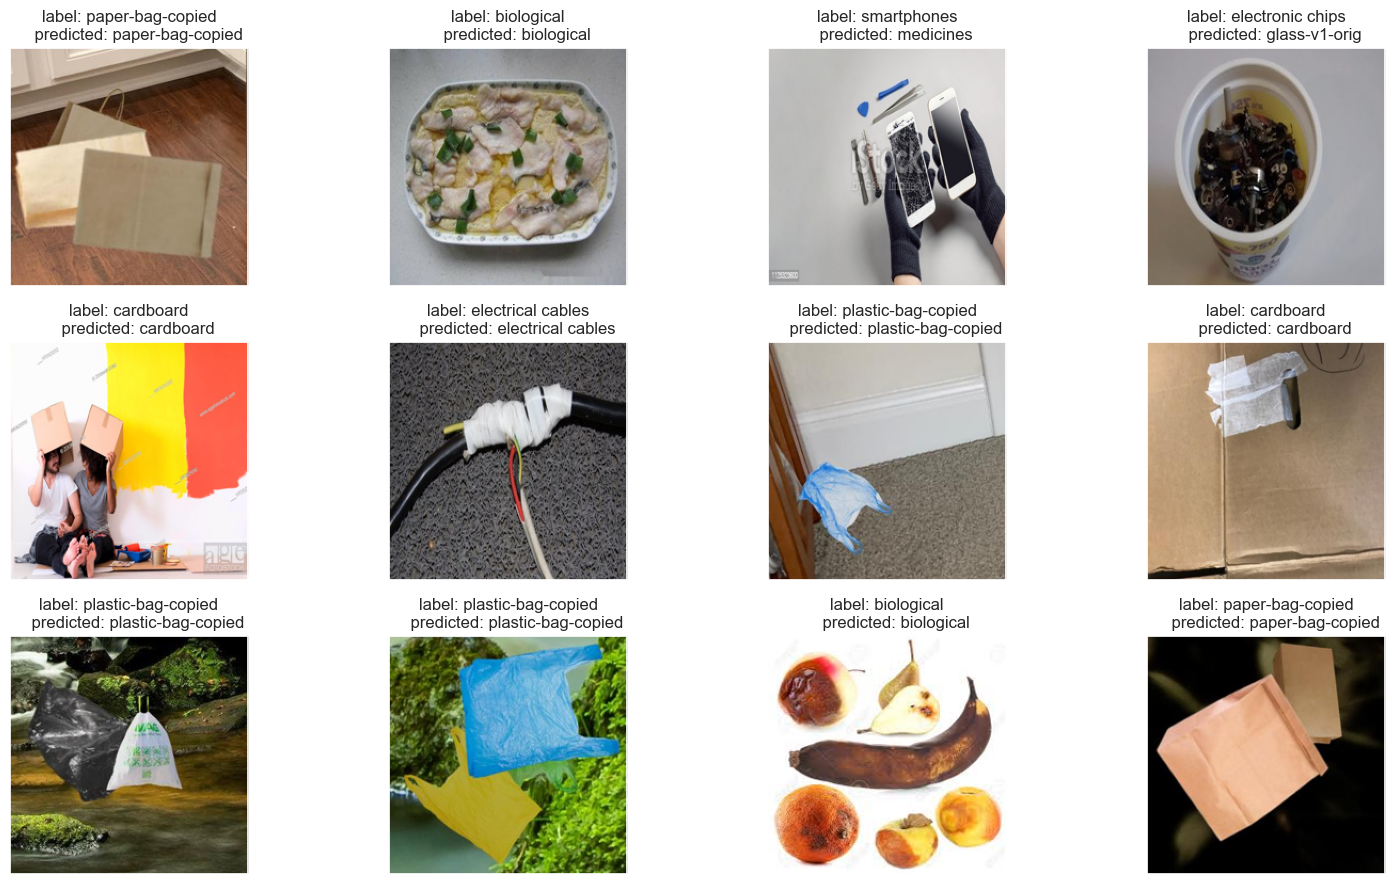

In [41]:
loss, accuracy = model_v1.evaluate(X_test_v2, y_test_v2)
print("loss / crossentropy / accuracy:")
print(loss)
print(accuracy)

y_pred_orig = model_v1.predict(X_test_v2)

y_pred = (y_pred_orig > 0.5) 

print(classification_report(y_test_v2, y_pred, target_names=categories_v2, digits=4))


# visualize 24 random results
sns.set(font_scale=1)
index = np.random.choice(np.arange(len(X_test_v2)), 12, replace=False)    # pick 24 random smamples
figure, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))           # set dimensions
for item in zip(axes.ravel(), X_test_v2[index], y_test_v2[index], y_pred[index]):          # put each sample into a "slot" in the table
    axes, image, target, predict = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    print(target)
    axes.set_title("label: " + categories_v2[np.argmax(target)] + '''
    predicted: ''' + categories_v2[np.argmax(predict)])
plt.tight_layout()
plt.show()   

<AxesSubplot: >

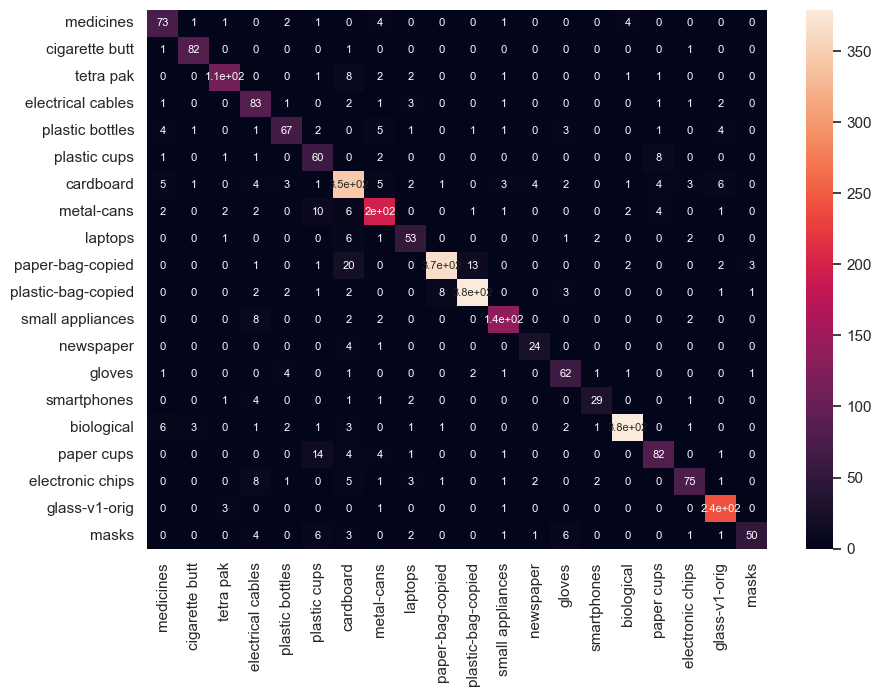

In [42]:
preds = []
labs = []
for i in range(len(y_pred_orig)):
    preds.append(np.where(y_pred_orig[i] == max(y_pred_orig[i]))[0][0])
    labs.append(np.where(y_test_v2[i] == 1)[0][0])


conf_matrix = tf.math.confusion_matrix(labs, preds)

df_cm = pd.DataFrame(conf_matrix, index = [i for i in categories_v2],
                  columns = [i for i in categories_v2])
plt.figure(figsize = (10,7))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

In [28]:
inputs = k.Input(shape=(img_res[0], img_res[1], 3))
x = data_augmentation(inputs)
x = base_model(x)
x = k.layers.GlobalAveragePooling2D() (x)
outputs = k.layers.Dense(len(categories_v2), activation = 'sigmoid') (x)

model_v2 = k.Model(inputs, outputs)

model_v2.compile(optimizer=k.optimizers.Adam(),
                loss=k.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
epoch_counter = 2

# actually running the cnn and fitting/training neural network on the data
# batch size = after 64 samples, make a small adjustment
# epoch = every time all the data is run through, make a big adjustment
with tf.device("/cpu:0"):       
    history = model_v2.fit(X_train_v2, y_train_v2, epochs=4, batch_size=64, validation_split=0.1, shuffle = True)  

2023-03-21 09:53:55.759850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 11s 98ms/step - loss: 0.4143 - accuracy: 0.8756
loss / crossentropy / accuracy:
0.4143061637878418
0.8756492137908936


2023-03-21 09:54:08.167452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 11s 94ms/step
                    precision    recall  f1-score   support

         medicines     0.9571    0.7701    0.8535        87
    cigarette butt     0.9647    0.9647    0.9647        85
         tetra pak     0.9355    0.9206    0.9280       126
 electrical cables     0.8571    0.6250    0.7229        96
   plastic bottles     0.8333    0.7143    0.7692        91
      plastic cups     0.9048    0.5205    0.6609        73
         cardboard     0.9088    0.8159    0.8598       391
        metal-cans     0.8618    0.8166    0.8386       229
           laptops     0.6494    0.7576    0.6993        66
  paper-bag-copied     0.9646    0.9338    0.9489       408
plastic-bag-copied     0.9837    0.9098    0.9453       399
  small appliances     0.9565    0.8742    0.9135       151
         newspaper     0.7600    0.6552    0.7037        29
            gloves     0.8333    0.8108    0.8219        74
       smartphones     0.6735    0.8462   

/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


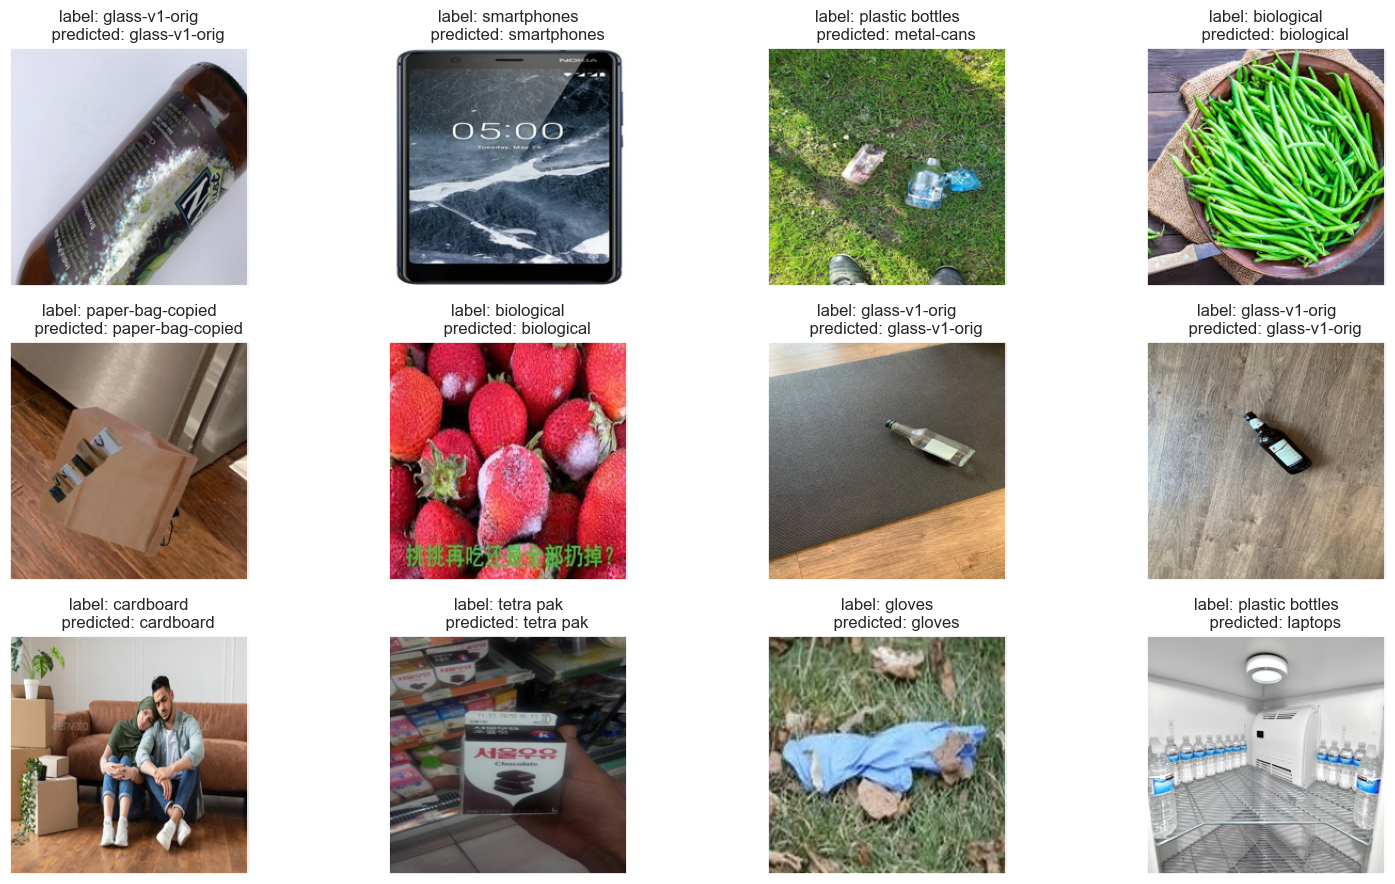

In [102]:
loss, accuracy = model_v2.evaluate(X_test_v2, y_test_v2)
print("loss / crossentropy / accuracy:")
print(loss)
print(accuracy)

"""
IF MODEL DOESNT KNOW, RETURN GARBAGE AND SAY WE'RE NOT QUITE SURE
Resource: https://www.ridwell.com/
"""

acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

y_pred_orig = model_v2.predict(X_test_v2)

y_pred = (y_pred_orig > 0.5) 

print(classification_report(y_test_v2, y_pred, target_names=categories_v2, digits=4))



# visualize 24 random results
sns.set(font_scale=1)
index = np.random.choice(np.arange(len(X_test_v2)), 12, replace=False)    # pick 24 random smamples
figure, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))           # set dimensions
for item in zip(axes.ravel(), X_test_v2[index], y_test_v2[index], y_pred[index]):          # put each sample into a "slot" in the table
    axes, image, target, predict = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    print(target)
    axes.set_title("label: " + categories_v2[np.argmax(target)] + '''
    predicted: ''' + categories_v2[np.argmax(predict)])
plt.tight_layout()
plt.show()   

In [24]:
import keras_tuner as kt

# data augmentation
with tf.device('/cpu:0'):
    data_augmentation_light = k.Sequential([
    RandomRotation(0.1, input_shape=(img_res[0], img_res[1], 3)),
    ])

    data_augmentation_heavy = k.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2, input_shape=(img_res[0], img_res[1], 3)),
    RandomZoom(0.2, 0.2),
    #RandomContrast(0.2),
    ])

base_model = k.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_res[0], img_res[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False


def build_model(hp):
    inputs = k.Input(shape=(img_res[0], img_res[1], 3))
    if hp.Boolean("data_aug_heavy"):
        x = data_augmentation_heavy(inputs)
    else:
        x = data_augmentation_light(inputs)
    x = base_model(x)
    x = k.layers.GlobalAveragePooling2D() (x)
    x = k.layers.Dense(units=hp.Int("dense1", min_value=32, max_value=1024, step=32),) (x)
    if hp.Boolean("dropout1"):
        x = k.layers.Dropout(0.2) (x)
    x = k.layers.Dense(units=hp.Int("dense2", min_value=32, max_value=512, step=32),) (x)
    if hp.Boolean("dropout2"):
        x = k.layers.Dropout(0.2) (x)
    if hp.Boolean("batchnorm"):
        x = k.layers.BatchNormalization() (x)
    outputs = k.layers.Dense(len(categories_v2), activation = 'softmax') (x)

    model = k.Model(inputs, outputs)

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(optimizer=k.optimizers.Adam(learning_rate = learning_rate),
                  loss=k.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=6,
    executions_per_trial=3,
    overwrite=True,
    directory="keras_tuner-model",
    project_name="waste_classification_model",
)

tuner.search_space_summary()


Search space summary
Default search space size: 7
data_aug_heavy (Boolean)
{'default': False, 'conditions': []}
dense1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
dropout1 (Boolean)
{'default': False, 'conditions': []}
dense2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout2 (Boolean)
{'default': False, 'conditions': []}
batchnorm (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [29]:
with tf.device("/cpu:0"):       
    tuner.search(X_train_v2, y_train_v2, epochs=3, validation_split = 0.1, batch_size = 64)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
True              |?                 |data_aug_heavy
256               |?                 |dense1
False             |?                 |dropout1
128               |?                 |dense2
False             |?                 |dropout2
False             |?                 |batchnorm
0.00010895        |?                 |lr

Epoch 1/3


2023-03-20 21:18:59.278921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


532/532 [==============================] - ETA: 0s - loss: 1.3306 - accuracy: 0.5999

2023-03-20 21:22:27.051330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


532/532 [==============================] - 230s 428ms/step - loss: 1.3306 - accuracy: 0.5999 - val_loss: 3.1976 - val_accuracy: 0.2415
Epoch 2/3
532/532 [==============================] - 237s 446ms/step - loss: 0.8504 - accuracy: 0.7341 - val_loss: 3.3833 - val_accuracy: 0.2421
Epoch 3/3
 51/532 [=>............................] - ETA: 3:15 - loss: 0.7890 - accuracy: 0.7506

KeyboardInterrupt: 

In [83]:
best_hps = tuner.get_best_hyperparameters(5)
model_tuned = build_model(best_hps[0])
print(model_tuned.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_18 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 32)                40992     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0   

Epoch 1/4


2023-03-13 13:16:57.744123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - ETA: 0s - loss: 1.1534 - accuracy: 0.5770

2023-03-13 13:17:26.049250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Saving model...
328/328 [==============================] - 35s 90ms/step - loss: 1.1534 - accuracy: 0.5770 - val_loss: 2.9698 - val_accuracy: 0.3527
Epoch 2/4
328/328 [==============================] - 21s 65ms/step - loss: 0.8371 - accuracy: 0.6886 - val_loss: 2.8277 - val_accuracy: 0.4007
Epoch 3/4
328/328 [==============================] - 21s 64ms/step - loss: 0.7189 - accuracy: 0.7416 - val_loss: 2.7954 - val_accuracy: 0.3459
Epoch 4/4
16/16 [==============================] - 5s 231ms/step - loss: 0.5833 - accuracy: 0.8063
loss / crossentropy / accuracy:
0.5833308100700378
0.8063241243362427


2023-03-13 13:18:40.308594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 5s 198ms/step
              precision    recall  f1-score   support

       paper     0.9861    0.6574    0.7889       108
       metal     0.7103    0.9268    0.8042        82
   cardboard     0.8667    0.9630    0.9123        81
       trash     0.8421    0.5517    0.6667        29
       glass     0.8481    0.6768    0.7528        99
     plastic     0.8875    0.6636    0.7594       107

   micro avg     0.8479    0.7490    0.7954       506
   macro avg     0.8568    0.7399    0.7807       506
weighted avg     0.8662    0.7490    0.7908       506
 samples avg     0.7490    0.7490    0.7490       506



/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0.]


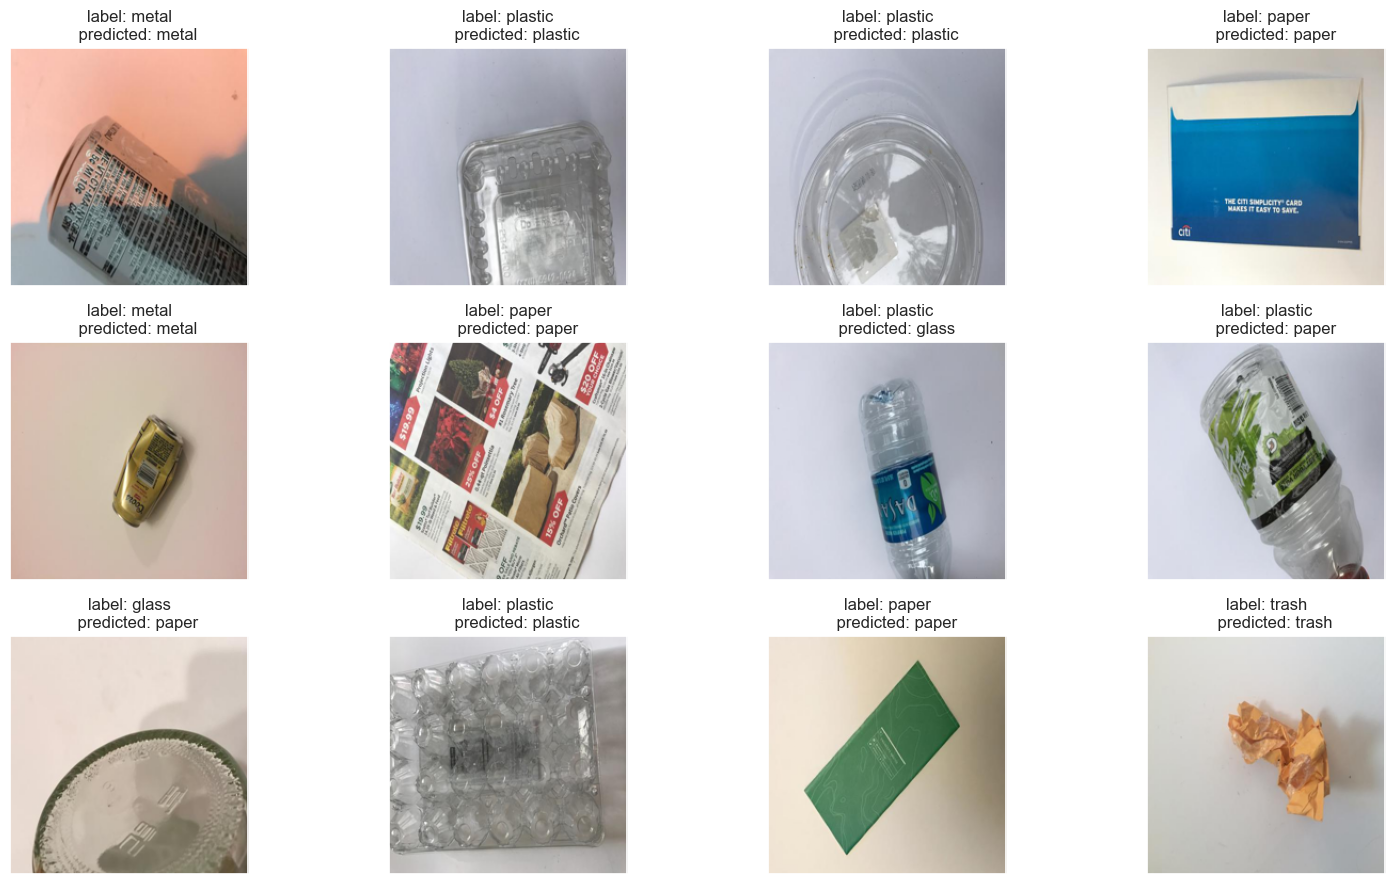

In [84]:
epoch_counter = 2

# actually running the cnn and fitting/training neural network on the data
# batch size = after 64 samples, make a small adjustment
# epoch = every time all the data is run through, make a big adjustment
with tf.device("/gpu:0"):       
    history = model_tuned.fit(X_train_v2, y_train_v2, epochs=4, batch_size=8, validation_split=0.1, shuffle = True, callbacks=[SaveModelCallback()])


# evalutating the loss/accuracy of the model on the test set
loss, accuracy = model_tuned.evaluate(X_test_v2, y_test_v2)
print("loss / crossentropy / accuracy:")
print(loss)
print(accuracy)

"""
IF MODEL DOESNT KNOW, RETURN GARBAGE AND SAY WE'RE NOT QUITE SURE
Resource: https://www.ridwell.com/
"""

acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

y_pred = model_tuned.predict(X_test_v2)

y_pred = (y_pred > 0.5) 

print(classification_report(y_test_v2, y_pred, target_names=categories_v2, digits=4))



# visualize 24 random results
sns.set(font_scale=1)
index = np.random.choice(np.arange(len(X_test_v2)), 12, replace=False)    # pick 24 random smamples
figure, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))           # set dimensions
for item in zip(axes.ravel(), X_test_v2[index], y_test_v2[index], y_pred[index]):          # put each sample into a "slot" in the table
    axes, image, target, predict = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    print(target)
    axes.set_title("label: " + categories_v2[np.argmax(target)] + '''
    predicted: ''' + categories_v2[np.argmax(predict)])
plt.tight_layout()
plt.show()   